# Import packages

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
sns.despine()
sns.set_context('talk', font_scale=1)

# Import dataset

In [2]:
data = pd.read_csv('train.csv', index_col='Id')
pd.set_option('display.max_columns', 100)
data.head()

,price,host_is_superhost,host_total_listings_count,host_identity_verified,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,security_deposit,cleaning_fee,extra_people,minimum_nights,maximum_nights,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,is_business_travel_ready,cancellation_policy,reviews_per_month
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,150,f,22.0,t,-33.846469,151.205171,Apartment,Entire home/apt,2,1.0,1,1.0,500.0,330.0,0,7,1125,1,100.0,10.0,10.0,10.0,10.0,10.0,10.0,f,f,strict,0.53
1,66,f,1.0,t,-33.895736,151.173529,Apartment,Private room,2,1.5,1,1.0,NaN,NaN,0,21,30,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,f,flexible,NaN
2,325,t,1.0,t,-33.879322,151.222408,House,Entire home/apt,4,2.0,2,2.0,500.0,180.0,0,3,90,21,99.0,10.0,10.0,10.0,10.0,10.0,9.0,f,f,moderate,2.38
3,145,f,1.0,f,-33.856874,151.149600,House,Entire home/apt,6,1.5,3,4.0,0.0,80.0,0,4,1125,3,100.0,10.0,10.0,10.0,10.0,10.0,10.0,f,f,flexible,1.96
4,200,f,6.0,t,-33.907150,151.178552,House,Entire home/apt,4,1.0,2,2.0,350.0,85.0,50,2,30,22,97.0,10.0,10.0,10.0,10.0,10.0,10.0,f,f,moderate,2.73


# Data Processing

In [3]:
# Missing data
missing_data = data.isnull().sum(axis=0).reset_index()
missing_data.columns = ['Predictor', 'Count of NaN values']
missing_data['Missing Ratio'] = missing_data['Count of NaN values'] / data.shape[0]
missing_data.loc[missing_data['Missing Ratio'] > 0]

,Predictor,Count of NaN values,Missing Ratio
1,host_is_superhost,2,0.002
2,host_total_listings_count,2,0.002
3,host_identity_verified,2,0.002
9,bathrooms,3,0.003
11,beds,2,0.002
12,security_deposit,426,0.426
13,cleaning_fee,307,0.307
18,review_scores_rating,340,0.340
19,review_scores_accuracy,342,0.342
20,review_scores_cleanliness,342,0.342


In [4]:
pd.crosstab(data['host_identity_verified'], data['host_identity_verified'])

host_identity_verified,f,t
host_identity_verified,,
f,509,0
t,0,489


In [5]:
pd.crosstab(data['host_is_superhost'], data['host_is_superhost'])

host_is_superhost,f,t
host_is_superhost,,
f,905,0
t,0,93


### Imputing missing data

In [6]:
# Categoricals
data['host_is_superhost'].fillna(value='f', inplace=True)
data['host_identity_verified'].fillna(value='f', inplace=True)

# No costs
data['security_deposit'].fillna(value=0, inplace=True)
data['cleaning_fee'].fillna(value=0, inplace=True)

# Medians
data['bathrooms'].fillna(value=np.nanmedian(data['bedrooms']), inplace=True)
data['beds'].fillna(value=np.nanmedian(data['beds']), inplace=True)
data['host_total_listings_count'].fillna(value=np.nanmedian(data['host_total_listings_count']), inplace=True)

#Reviews
review_data = data.filter(regex='review')

no_reviews = review_data.loc[review_data['number_of_reviews'] == 0]
reviews = review_data.loc[review_data['number_of_reviews'] > 0]

no_reviews = no_reviews.fillna(value=0)
review_data = pd.concat([reviews, no_reviews], ignore_index=False).sort_index()

from sklearn.preprocessing import Imputer
impute = Imputer(strategy='median')
review_data_clean = impute.fit_transform(review_data)
review_data_clean = pd.DataFrame(review_data_clean, columns=review_data.columns)

# Combining cleaned data
data = data.drop(columns=review_data.columns)
data = pd.concat([data, review_data_clean], axis=1)
data.head()

,price,host_is_superhost,host_total_listings_count,host_identity_verified,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,security_deposit,cleaning_fee,extra_people,minimum_nights,maximum_nights,instant_bookable,is_business_travel_ready,cancellation_policy,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,150,f,22.0,t,-33.846469,151.205171,Apartment,Entire home/apt,2,1.0,1,1.0,500.0,330.0,0,7,1125,f,f,strict,1.0,100.0,10.0,10.0,10.0,10.0,10.0,10.0,0.53
1,66,f,1.0,t,-33.895736,151.173529,Apartment,Private room,2,1.5,1,1.0,0.0,0.0,0,21,30,f,f,flexible,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
2,325,t,1.0,t,-33.879322,151.222408,House,Entire home/apt,4,2.0,2,2.0,500.0,180.0,0,3,90,f,f,moderate,21.0,99.0,10.0,10.0,10.0,10.0,10.0,9.0,2.38
3,145,f,1.0,f,-33.856874,151.149600,House,Entire home/apt,6,1.5,3,4.0,0.0,80.0,0,4,1125,f,f,flexible,3.0,100.0,10.0,10.0,10.0,10.0,10.0,10.0,1.96
4,200,f,6.0,t,-33.907150,151.178552,House,Entire home/apt,4,1.0,2,2.0,350.0,85.0,50,2,30,f,f,moderate,22.0,97.0,10.0,10.0,10.0,10.0,10.0,10.0,2.73


### Separating predictors into their datatypes for later

In [7]:
response = ['price']

categorical = ['host_is_superhost', 'host_identity_verified', 'property_type', 'room_type',
               'instant_bookable', 'is_business_travel_ready', 'cancellation_policy']

continuous = ['host_total_listings_count', 'security_deposit', 'cleaning_fee', 'extra_people',
              'minimum_nights','maximum_nights']

discrete = ['accommodates', 'bathrooms', 'bedrooms', 'beds']

reviews = ['number_of_reviews', 'review_scores_rating', 'review_scores_accuracy', 
           'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 
           'review_scores_location', 'review_scores_value', 'reviews_per_month']

coordinates = ['latitude', 'longitude']

predictors = categorical + continuous + discrete + reviews + coordinates

# Exploratory Data Analysis

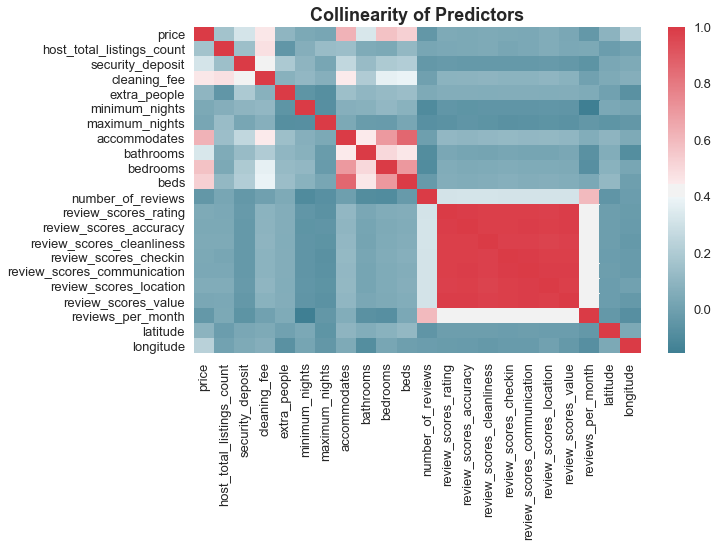

In [8]:
# Correlation matrix for all variables against each other
fig, ax = plt.subplots(figsize=(10,6))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(data[response+predictors].corr(), ax=ax, cmap=cmap)
ax.set_title('Collinearity of Predictors', fontweight='bold', fontsize=18)

plt.show()
#fig.savefig('Collinearity of Predictors.png')

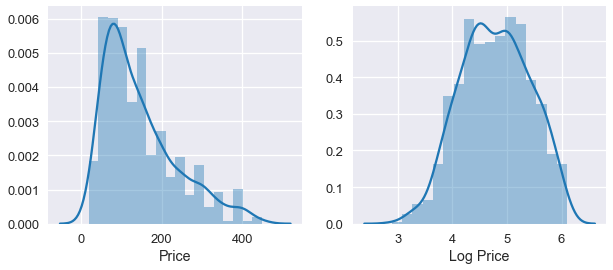

In [9]:
# Distribution of price

fig, ax = plt.subplots(1, 2, figsize=(10,4))

sns.distplot(data['price'], ax=ax[0])
ax[0].set_xlabel('Price')

sns.distplot(np.log(data['price']), ax=ax[1])
ax[1].set_xlabel('Log Price')

plt.show()

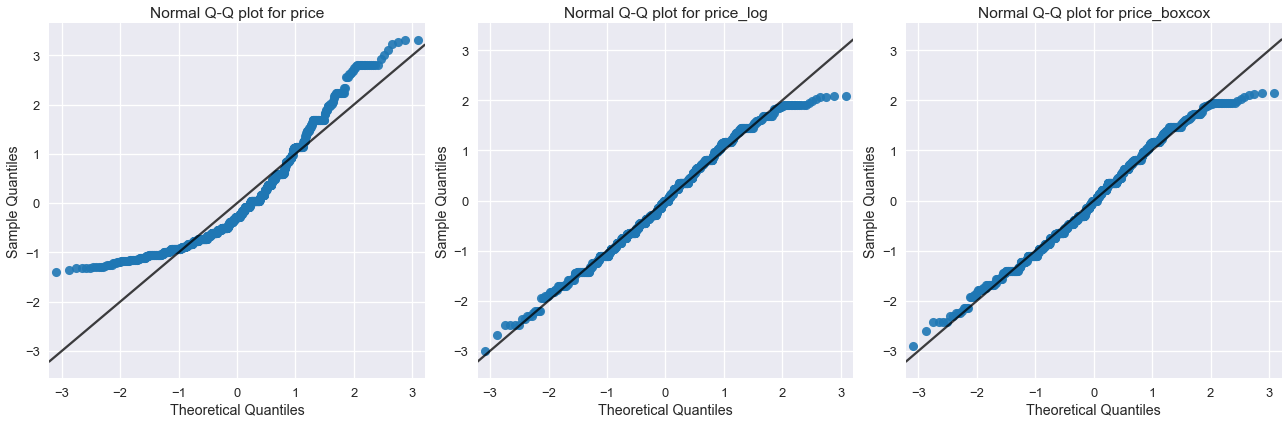

In [10]:
import scipy
from scipy import stats

# Normality of price
data['price_log'] = np.log(data['price'])
data['price_boxcox'] = scipy.stats.boxcox(data['price'])[0]

import statsmodels.api as sm
label = ['price', 'price_log', 'price_boxcox']

fig, ax = plt.subplots(1, 3, figsize = (18,6))
i = 0
for series in label:
    pp = sm.ProbPlot(data[series], fit=True)
    qq = pp.qqplot(color=sns.color_palette()[0], alpha=0.9, ax=ax[i])
    a = ax[i].get_xlim()[0]
    b = ax[i].get_xlim()[1]
    ax[i].plot([a,b], [a,b], color='black', alpha=0.75)
    ax[i].set_xlim(a, b)
    ax[i].set_title('Normal Q-Q plot for {}'.format(series))
    i += 1

plt.tight_layout()
plt.show()

In [11]:
data = data.drop(columns=['price_log', 'price_boxcox'])

In [12]:
from scipy import stats

# Non-parametric Kruskal-Wallis ANOVA rank test - discrete variables
H = []
p = []

for i in categorical+discrete:
    h, pval = stats.kruskal(*[data.loc[data[i]==v,'price'] for v in data[i].unique()])
    H.append(h)
    p.append(pval)

# Calculates significance at 1% and appends results
test_results = []
for value in p:
    if value < 0.01:
        test_results.append('True')
    else:
        test_results.append('False')

# Creates tables with the values above
table = pd.DataFrame(H, columns=['H Stat'], index=categorical+discrete)
table['p values'] = pd.DataFrame(p, index=categorical+discrete)
table['Reject, \u03b1=0.01'] = pd.DataFrame(test_results, index=categorical+discrete)

table.round(2)

,H Stat,p values,"Reject, α=0.01"
host_is_superhost,0.55,0.46,False
host_identity_verified,13.43,0.00,True
property_type,33.54,0.01,False
room_type,533.00,0.00,True
instant_bookable,2.97,0.08,False
is_business_travel_ready,10.81,0.00,True
cancellation_policy,76.36,0.00,True
accommodates,456.46,0.00,True
bathrooms,70.39,0.00,True
bedrooms,351.51,0.00,True


In [13]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

pred = continuous + discrete + reviews + coordinates

X = data[pred].as_matrix()
VIF = pd.DataFrame([np.sqrt(variance_inflation_factor(X,j)) for j in range(len(pred))], index=pred, columns=['SQRT(VIF)'])

VIF.sort_values(by='SQRT(VIF)', ascending=False).round(2)

,SQRT(VIF)
longitude,484.33
latitude,484.31
review_scores_rating,17.13
review_scores_communication,17.13
review_scores_checkin,16.30
review_scores_value,15.24
review_scores_accuracy,15.19
review_scores_location,12.73
review_scores_cleanliness,11.40
accommodates,4.25


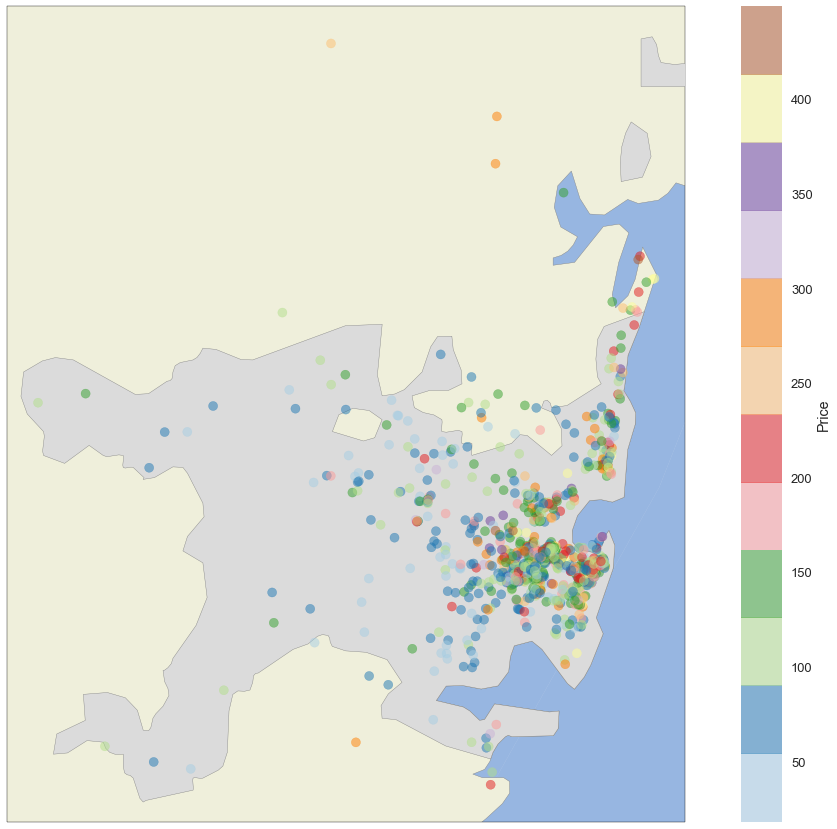

In [14]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

plt.figure(figsize = (20,15)) # Plot

ax = plt.axes(projection=ccrs.Mercator()) # Map projection
ax.coastlines(resolution='10m') 

land = cfeature.NaturalEarthFeature(category='physical', name='land', scale='10m',
                                    facecolor=cfeature.COLORS['land'])

pop = cfeature.NaturalEarthFeature(category='cultural', name='urban_areas', scale='10m', 
                                   facecolor=cfeature.COLORS['land_alt1'])

ax.add_feature(cfeature.LAND, facecolor=cfeature.COLORS['water'], zorder=1)
ax.add_feature(cfeature.OCEAN, zorder=1)

ax.add_feature(pop, edgecolor='gray', zorder=3)
ax.add_feature(land, edgecolor='gray', zorder=2)

plt.scatter(data['longitude'], data['latitude'], c=data['price'], alpha=0.5, transform=ccrs.Geodetic(), 
            cmap='Paired', zorder=8)

plt.colorbar().set_label('Price')
plt.show()

# Feature Engineering

In [15]:
# Dummies
dummies = pd.get_dummies(data[categorical], columns=categorical, drop_first=True)

data = data.drop(columns=data[categorical].columns)
data = pd.concat([data, dummies], axis=1)

In [16]:
# New variables

data['fee_per_person'] = (data['security_deposit'] + data['cleaning_fee']) / data['accommodates']

data['beds_per_person'] = data['beds'] / data['accommodates']

data['bathrooms_per_person'] = data['bathrooms'] / data['accommodates']

# These return errors due to dividing by 0 probably
#data['beds_per_bedroom'] = data['bedrooms'] / data['accomodates']

#data['bedrooms_per_person'] = data['bedrooms'] / data['accommodates']

#data['beds_per_bedrooms'] = data['beds'] / data['bedrooms']

In [17]:
# Combination of reviews
review_combination = ['review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin',
                      'review_scores_communication', 'review_scores_location', 'review_scores_value']

data['average_review'] = data[review_combination].mean(axis=1)

data = data.drop(columns=data[review_combination].columns)

In [18]:
# Function to calculate distance between A and B with lat/lon
# https://stackoverflow.com/questions/15736995/how-can-i-quickly-estimate-the-distance-between-two-latitude-longitude-points
# Alternative could be clustering (kmeans) or something like s2-geometry-library or geohash

from math import radians, cos, sin, asin, sqrt
def great_circle_dist(lat1, lon1, lat2, lon2):
    # convert decimal degrees to radians 
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
   
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    
    # radius of earth in kilometers is 6371
    km = 6371 * c
    return km

In [19]:
%%time
syd_lat, syd_lon = -33.8587377, 151.210686

distance = []
for i in np.arange(len(data)):
    lat = data['latitude'].iloc[i]
    lon = data['longitude'].iloc[i]
    
    dist = great_circle_dist(syd_lat, syd_lon, lat, lon)
    distance.append(dist)

Wall time: 40 ms


In [20]:
data = data.drop(columns=data[coordinates].columns)
distance = pd.DataFrame(distance, columns=['distance'])
data = pd.concat([data, distance], axis=1)

In [21]:
# Final dataset
data.head()

,price,host_total_listings_count,accommodates,bathrooms,bedrooms,beds,security_deposit,cleaning_fee,extra_people,minimum_nights,maximum_nights,number_of_reviews,review_scores_rating,reviews_per_month,host_is_superhost_t,host_identity_verified_t,property_type_Bed & Breakfast,property_type_Boat,property_type_Boutique hotel,property_type_Bungalow,property_type_Cabin,property_type_Condominium,property_type_Dorm,property_type_Guest suite,property_type_Guesthouse,property_type_Hostel,property_type_House,property_type_In-law,property_type_Loft,property_type_Other,property_type_Timeshare,property_type_Townhouse,property_type_Vacation home,property_type_Villa,room_type_Private room,room_type_Shared room,instant_bookable_t,is_business_travel_ready_t,cancellation_policy_moderate,cancellation_policy_strict,fee_per_person,beds_per_person,bathrooms_per_person,average_review,distance
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,150,22.0,2,1.0,1,1.0,500.0,330.0,0,7,1125,1.0,100.0,0.53,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,415.000000,0.500000,0.50,10.000000,1.456145
1,66,1.0,2,1.5,1,1.0,0.0,0.0,0,21,30,0.0,0.0,0.00,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0.000000,0.500000,0.75,0.000000,5.356449
2,325,1.0,4,2.0,2,2.0,500.0,180.0,0,3,90,21.0,99.0,2.38,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,170.000000,0.500000,0.50,9.833333,2.531821
3,145,1.0,6,1.5,3,4.0,0.0,80.0,0,4,1125,3.0,100.0,1.96,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,13.333333,0.666667,0.25,10.000000,5.644431
4,200,6.0,4,1.0,2,2.0,350.0,85.0,50,2,30,22.0,97.0,2.73,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,108.750000,0.500000,0.25,10.000000,6.146362


# Models

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score,  mean_absolute_error

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
import xgboost as xgb
import lightgbm as lgb
from mlxtend.regressor import StackingCVRegressor

In [23]:
response = 'price'
predictors = [x for x in list(data.columns) if x not in response]

# Randomly split indexes
index_train, index_test  = train_test_split(np.array(data.index), train_size=0.7, random_state=42)

# Write training and test sets 
train = data.loc[index_train, :].copy()
test =  data.loc[index_test, :].copy()

# Write training and test response vectors
y_train = np.log(train[response])
y_test = np.log(test[response])

# Write training and test design matrices
X_train = train[predictors].copy()
X_test = test[predictors].copy()

### Linear Regression

In [24]:
ols = LinearRegression()
ols.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

### Lasso

In [25]:
lasso = Pipeline((
    ('scaler', StandardScaler()),
    ('estimator', LassoCV(cv=5)),
))

lasso.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('estimator', LassoCV(alphas=None, copy_X=True, cv=5, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=1, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False))])

### Ridge

In [26]:
alphas = list(np.logspace(-15, 15, 151, base=2))

ridge = Pipeline((
    ('scaler', StandardScaler()),
    ('estimator', RidgeCV(alphas=alphas, cv=5)),
))

ridge.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('estimator', RidgeCV(alphas=[3.0517578125e-05, 3.505549179068098e-05, 4.026818575356734e-05, 4.625599873383782e-05, 5.313418965430448e-05, 6.103515625e-05, 7.011098358136196e-05, 8.053637150713468e-05, 9.251199746767564e-0...cv=5, fit_intercept=True, gcv_mode=None, normalize=False, scoring=None,
    store_cv_values=False))])

### Elastic Net

In [27]:
enet = Pipeline((
    ('scaler', StandardScaler()),
    ('estimator', ElasticNetCV(l1_ratio=[0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9, 0.99], cv=5)),
))

enet.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('estimator', ElasticNetCV(alphas=None, copy_X=True, cv=5, eps=0.001, fit_intercept=True,
       l1_ratio=[0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99],
       max_iter=1000, n_alphas=100, n_jobs=1, normalize=False,
       positive=False, precompute='auto', random_state=None,
       selection='cyclic', tol=0.0001, verbose=0))])

### Regression Tree

In [28]:
%%time

model = DecisionTreeRegressor(min_samples_leaf=5)

tuning_parameters = {
    'min_samples_leaf': [1,5,10,20],
    'max_depth': np.arange(1,30),
}

tree = RandomizedSearchCV(model, tuning_parameters, n_iter=20, cv=5, return_train_score=False)
tree.fit(X_train, y_train)

print('Best parameters:', tree.best_params_)

Best parameters: {'min_samples_leaf': 1, 'max_depth': 3}
Wall time: 465 ms


### Bagging

In [29]:
%%time

bag = BaggingRegressor(n_estimators=500, random_state=1)
bag.fit(X_train, y_train)

Wall time: 2.43 s


### Random Forest

In [30]:
%%time

model = RandomForestRegressor(n_estimators=100)

tuning_parameters = {
    'min_samples_leaf': [1,5, 10, 20, 50],
    'max_features': np.arange(1, X_train.shape[1], 5),
}

rf_search = RandomizedSearchCV(model, tuning_parameters, cv = 5, n_iter= 16, return_train_score=False, n_jobs=4,
                              random_state = 20)
rf_search.fit(X_train, y_train)

rf = rf_search.best_estimator_

print('Best parameters found by randomised search:', rf_search.best_params_, '\n')

Best parameters found by randomised search: {'min_samples_leaf': 1, 'max_features': 41} 

Wall time: 15.8 s


In [31]:
rf.n_estimators = 500
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=41, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

### Boosting

In [32]:
from sklearn.ensemble import GradientBoostingRegressor

gb = GradientBoostingRegressor(learning_rate= 0.05, max_depth = 4, n_estimators= 750, subsample = 1.0)
gb.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.05, loss='ls', max_depth=4, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=750, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

In [33]:
%%time

model = GradientBoostingRegressor()

tuning_parameters = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators' : [250, 500, 750, 1000, 1500],
    'max_depth' : [2 ,3, 4],
    'subsample' : [0.6, 0.8, 1.0]
}

# Using GridSearchCV would be too slow. Increase the number of iterations to explore more hyperparameter combinations.
gb = RandomizedSearchCV(model, tuning_parameters, n_iter = 20, cv = 10, return_train_score=False, n_jobs=4)
gb.fit(X_train, y_train)

print('Best parameters found by randomised search:', gb.best_params_, '\n')

Best parameters found by randomised search: {'subsample': 0.8, 'n_estimators': 750, 'max_depth': 3, 'learning_rate': 0.01} 

Wall time: 1min 22s


In [34]:
gb.best_estimator_

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.01, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=750, presort='auto', random_state=None,
             subsample=0.8, verbose=0, warm_start=False)

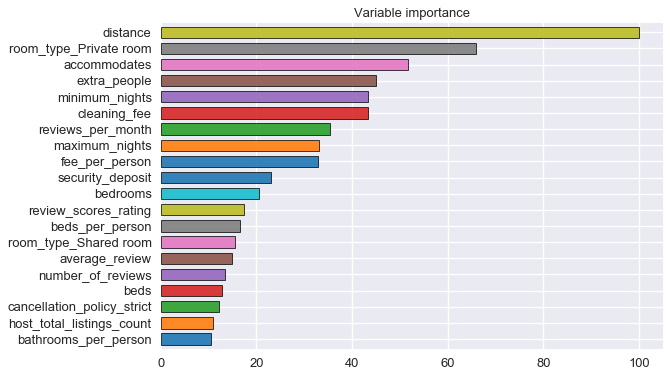

In [35]:
from statlearning import plot_feature_importance

plot_feature_importance(gb.best_estimator_, predictors)
plt.show()

### XGBoost

In [36]:
%%time

model = xgb.XGBRegressor()

tuning_parameters = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators' : [250, 500, 750, 1000, 1500],
    'max_depth' : [2, 3, 4],
    'subsample' : [0.6, 0.8, 1.0],
}

gb_search = RandomizedSearchCV(model, tuning_parameters, n_iter = 16, cv = 5, return_train_score=False, n_jobs=4,
                              random_state = 20)
gb_search.fit(X_train, y_train)

xbst = gb_search.best_estimator_

print('Best parameters found by randomised search:', gb_search.best_params_, '\n')

Best parameters found by randomised search: {'subsample': 0.8, 'n_estimators': 250, 'max_depth': 2, 'learning_rate': 0.05} 

Wall time: 39.3 s


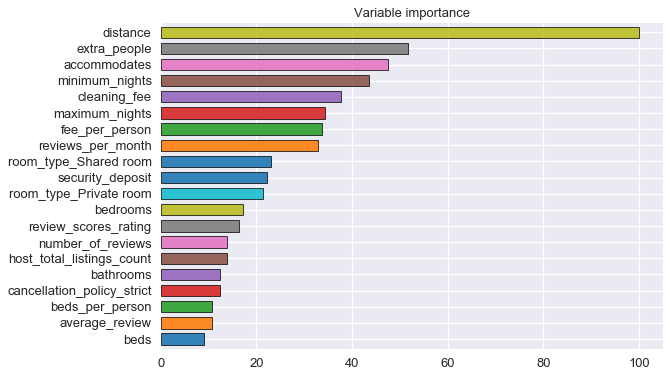

In [37]:
plot_feature_importance(xbst, labels=predictors)
plt.show()

In [38]:
%%time

dtrain = xgb.DMatrix(X_train, y_train) # we need to convert the data to the format required by xgboost
dtest  = xgb.DMatrix(X_test)

param = {
    'max_depth': 2, 
    'learning_rate': 0.1, 
    'subsample': 0.8,
    'silent' : 0, 
    'objective':'reg:linear',  
     }

cv = xgb.cv(param, dtrain, num_boost_round = 1500, nfold=10, early_stopping_rounds=50)

print(f'Selected number of boosting iterations: {cv.shape[0]}')
print(f'RMSE (CV): {cv.iloc[-1,0]:.4f}')

Selected number of boosting iterations: 115
RMSE (CV): 0.3786
Wall time: 3.27 s


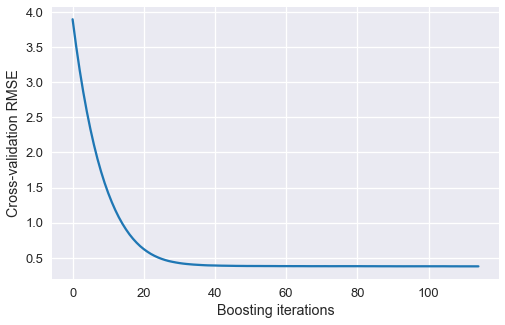

In [39]:
fig, ax = plt.subplots(figsize=(8,5))
plt.plot(cv.iloc[:,0])
ax.set_ylabel('Cross-validation RMSE')
ax.set_xlabel('Boosting iterations')
sns.despine()
plt.show()

### LightGBM

In [40]:
%%time

model = lgb.LGBMRegressor(objective='regression')

tuning_parameters = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators' : [250, 500, 750, 1000, 1500],
    'max_depth' : [2, 3, 4],
    'subsample' : [0.6, 0.8, 1.0],
}

gb_search = RandomizedSearchCV(model, tuning_parameters, n_iter = 64, cv = 5, return_train_score=False, n_jobs=4, 
                               random_state = 20)

gb_search.fit(X_train, y_train)

lbst = gb_search.best_estimator_

print('Best parameters found by randomised search:', gb_search.best_params_, '\n')

Best parameters found by randomised search: {'subsample': 0.8, 'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.01} 

Wall time: 2min 5s


### Adaptive Boosting

In [41]:
%%time

y_fit = lasso.predict(X_train)
resid = y_train - y_fit

model = lgb.LGBMRegressor(objective='regression')


tuning_parameters = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators' : [250, 500, 750, 1000, 1500],
    'max_depth' : [2, 3, 4],
    'subsample' : [0.6, 0.8, 1.0],
}

gb_search = RandomizedSearchCV(model, tuning_parameters, n_iter = 16, cv = 5, return_train_score=False, n_jobs=4, 
                               random_state = 20)

gb_search.fit(X_train, resid)

abst = gb_search.best_estimator_

print('Best parameters found by randomised search:', gb_search.best_params_, '\n')

Best parameters found by randomised search: {'subsample': 0.8, 'n_estimators': 250, 'max_depth': 2, 'learning_rate': 0.01} 

Wall time: 37.7 s


### Model Stacking

In [42]:
%%time

#models = [ols, lasso, ridge, xbst]
models = [enet, rf, xbst, lbst]

stack = StackingCVRegressor(models, meta_regressor = LinearRegression(), cv=10)
stack.fit(X_train.values, y_train.ravel())

Wall time: 39 s


# Evaluation

In [43]:
# Original Prices
columns=['Test RMSE', 'Test R2']
rows=['OLS', 'Lasso', 'Ridge', 'Elastic Net', 'Tree', 'Bagged Trees', 'Random Forest', 'SKLearn Boost', 'XGBoost', 'LightGBM', 'Additive Boost', 'Stack']
results=pd.DataFrame(0.0, columns=columns, index=rows) 

methods=[ols, lasso, ridge, enet, tree, bag, rf, gb, xbst, lbst, abst, stack]

for i, method in enumerate(methods):
    
    if method != stack:
        y_pred=np.exp(method.predict(X_test))   
        if method == abst:
            y_pred=np.exp(lasso.predict(X_test)+method.predict(X_test)) # combining predictions           
    else:
        y_pred=np.exp(method.predict(X_test.values))
        
    results.iloc[i,0] = np.sqrt(mean_squared_error(np.exp(y_test), y_pred))
    results.iloc[i,1] = r2_score(np.exp(y_test), y_pred)

results.round(3)

,Test RMSE,Test R2
OLS,65.352,0.469
Lasso,64.965,0.475
Ridge,66.276,0.454
Elastic Net,65.187,0.472
Tree,66.963,0.443
Bagged Trees,64.112,0.489
Random Forest,64.408,0.484
SKLearn Boost,64.073,0.490
XGBoost,64.370,0.485
LightGBM,65.199,0.472


In [44]:
# Log Prices
columns=['Test RMSE', 'Test R2']
rows=['OLS', 'Lasso', 'Ridge', 'Elastic Net', 'Tree', 'Bagged Trees', 'Random Forest', 'SKLearn Boost', 'XGBoost', 'LightGBM', 'Additive Boost', 'Stack']
results=pd.DataFrame(0.0, columns=columns, index=rows) 

methods=[ols, lasso, ridge, enet, tree, bag, rf, gb, xbst, lbst, abst, stack]

for i, method in enumerate(methods):
    
    if method != stack:
        y_pred= method.predict(X_test)   
        if method == abst:
            y_pred=ols.predict(X_test)+method.predict(X_test)              
    else:
        y_pred= method.predict(X_test.values)
        
    results.iloc[i,0] = np.sqrt(mean_squared_error(y_test, y_pred))
    results.iloc[i,1] = r2_score(y_test, y_pred)

results.round(3)

,Test RMSE,Test R2
OLS,0.389,0.609
Lasso,0.387,0.614
Ridge,0.393,0.601
Elastic Net,0.388,0.612
Tree,0.415,0.555
Bagged Trees,0.390,0.607
Random Forest,0.394,0.599
SKLearn Boost,0.387,0.614
XGBoost,0.388,0.612
LightGBM,0.422,0.541


# Prediction
Re-running all imputation and feature engineering on test set

In [45]:
test = pd.read_csv('test.csv', index_col='Id')
data = test.copy()

data['host_is_superhost'].fillna(value='f', inplace=True)
data['host_identity_verified'].fillna(value='f', inplace=True)

# No costs
data['security_deposit'].fillna(value=0, inplace=True)
data['cleaning_fee'].fillna(value=0, inplace=True)

# Medians
data['bathrooms'].fillna(value=np.nanmedian(data['bedrooms']), inplace=True)
data['beds'].fillna(value=np.nanmedian(data['beds']), inplace=True)
data['host_total_listings_count'].fillna(value=np.nanmedian(data['host_total_listings_count']), inplace=True)

#Reviews
review_data = data.filter(regex='review')

no_reviews = review_data.loc[review_data['number_of_reviews'] == 0]
reviews = review_data.loc[review_data['number_of_reviews'] > 0]

no_reviews = no_reviews.fillna(value=0)
review_data = pd.concat([reviews, no_reviews], ignore_index=False).sort_index()

from sklearn.preprocessing import Imputer
impute = Imputer(strategy='median')
review_data_clean = impute.fit_transform(review_data)
review_data_clean = pd.DataFrame(review_data_clean, columns=review_data.columns)

# Combining cleaned data
data = data.drop(columns=review_data.columns)
data = pd.concat([data, review_data_clean], axis=1)

# Dummies
dummies = pd.get_dummies(data[categorical], columns=categorical, drop_first=True)
data = data.drop(columns=data[categorical].columns)
data = pd.concat([data, dummies], axis=1)

# Distance
syd_lat, syd_lon = -33.8587377, 151.210686

distance = []
for i in np.arange(len(data)):
    lat = data['latitude'].iloc[i]
    lon = data['longitude'].iloc[i]
    
    dist = great_circle_dist(syd_lat, syd_lon, lat, lon)
    distance.append(dist)
    
data = data.drop(columns=data[coordinates].columns)
distance = pd.DataFrame(distance, columns=['distance'])
data = pd.concat([data, distance], axis=1)

# New variables
data['fee_per_person'] = (data['security_deposit'] + data['cleaning_fee']) / data['accommodates']
data['beds_per_person'] = data['beds'] / data['accommodates']
data['bathrooms_per_person'] = data['bathrooms'] / data['accommodates']

# Combination of reviews
review_combination = ['review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin',
                      'review_scores_communication', 'review_scores_location', 'review_scores_value']
data['average_review'] = data[review_combination].mean(axis=1)
data = data.drop(columns=data[review_combination].columns)

data.head()

,host_total_listings_count,accommodates,bathrooms,bedrooms,beds,security_deposit,cleaning_fee,extra_people,minimum_nights,maximum_nights,number_of_reviews,review_scores_rating,reviews_per_month,host_is_superhost_t,host_identity_verified_t,property_type_Bed & Breakfast,property_type_Boat,property_type_Boutique hotel,property_type_Bungalow,property_type_Cabin,property_type_Camper/RV,property_type_Castle,property_type_Chalet,property_type_Condominium,property_type_Dorm,property_type_Earth House,property_type_Guest suite,property_type_Guesthouse,property_type_Heritage hotel (India),property_type_Hostel,property_type_House,property_type_In-law,property_type_Island,property_type_Loft,property_type_Other,property_type_Serviced apartment,property_type_Tent,property_type_Townhouse,property_type_Train,property_type_Vacation home,property_type_Villa,property_type_Yurt,room_type_Private room,room_type_Shared room,instant_bookable_t,is_business_travel_ready_t,cancellation_policy_moderate,cancellation_policy_strict,distance,fee_per_person,beds_per_person,bathrooms_per_person,average_review
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1.0,3,1.0,1.0,1.0,131.0,60.0,20,5,1125,55.0,93.0,2.23,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,3.628710,63.666667,0.333333,0.333333,9.666667
1,1.0,4,1.0,2.0,2.0,200.0,100.0,0,2,1125,0.0,0.0,0.00,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,5.730587,75.000000,0.500000,0.250000,0.000000
2,1.0,5,1.0,2.0,4.0,400.0,100.0,0,6,35,10.0,96.0,0.80,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,10.345569,100.000000,0.800000,0.200000,9.833333
3,1.0,2,1.0,1.0,1.0,0.0,30.0,20,2,1125,3.0,80.0,0.08,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2.141212,15.000000,0.500000,0.500000,8.000000
4,52.0,4,1.0,1.0,2.0,500.0,120.0,20,3,1125,5.0,80.0,0.09,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,6.353274,155.000000,0.500000,0.250000,8.333333


In [46]:
# To fill the missing bedroom values in test set
data['bedrooms'].fillna(value=np.nanmedian(data['bedrooms']), inplace=True)

# To add the Timeshare property that isn't in the test set
data['property_type_Timeshare'] = 0

In [47]:
# Using Stack method
y_pred = np.exp(stack.predict(data[predictors].values))
submission = pd.DataFrame(np.c_[data.index, y_pred], columns=['Id', 'price'])
submission.to_csv('kaggle_submission.csv',  index=False)